# Introduction

The [Laplace transform of a continuous random variable](https://en.wikipedia.org/wiki/Laplace_transform#Probability_theory) $X$ with probability density function (PDF) $f_X$ 
is given by:
    $$\mathcal{L}_X(u)=\operatorname{E}\! \left[e^{-Xu} \right] = \int_{-\infty}^{\infty} f_X(x)e^{-x\,u}\,dx $$
where $\operatorname{E}$  represents the expectation.

The purpose of this work is to explore the Laplace transform of a [lognormal distributed random variable](https://en.wikipedia.org/wiki/Log-normal_distribution). For the lognormal distributed random variable $X \sim LogN(\mu,v)$ we have $Y=\log(X) \sim N(\mu,v)$, where $\mu$ and $v$ are the expectation and the variance of $\log(X)$ and $N$ denote a normal distribution. So we use second parametrization from https://en.wikipedia.org/wiki/Log-normal_distribution#Alternative_parameterizations . For the $X$ PDF in this parametrization we have: 
$$f_{X}(x,\mu,v)= \frac {1} {\sqrt{2\pi\,v}} \frac{1}{x} \exp\left( -\frac{(\ln x-\mu)^2}{2 v} \right) .$$

Finally
$$\mathcal{L}(u,\mu,v)=\frac {1} {\sqrt{2\pi\,v}} \int_0^{\infty}  \frac{1}{x}\exp(-x\,u) \exp\left(-\frac{(\ln x-\mu)^2}{2 v}\right) dx$$

There is no closed form formula for the above integral. However, we can use direct numerical integration, but first we substitute variables to simplify the calculations. Let's $Y=\ln(X)$ and $x=\exp(y)$

$$\mathcal{L}(u,\mu,v)=\operatorname{E}\! \left[e^{-e^Yu} \right]=\frac {1} {\sqrt{2\pi\,v}} \int_{-\infty}^{\infty} \exp\left(-e^yu-\frac{(y-\mu)^2}{2 v}\right) dy$$
$$=\frac {1} {\sqrt{2\pi}} \int_{-\infty}^{\infty} \exp\left(-e^{z\sigma+\mu}u-\frac{z^2}{2}\right) dz$$
where $\sigma=\sqrt{v}$, $z=(y-\mu)/\sigma$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as scsp
from scipy.special import lambertw
from scipy.integrate import quad
from IPython.display import display, Math
plt.style.use('seaborn-v0_8-darkgrid')


In [2]:
def LaplTrLNDirect(u,mu,v):
    max_exp=744.0 # np.exp(-max_exp) - minimal double value to calculate without overflow
    def LLN(t): #calculates the Laplace transform for scalar t
        if t==0:
            return np.sqrt(2.0*np.pi*v)
        
        sigma=np.sqrt(v)
        def F(z): #integrand
            s=np.exp(z*sigma+mu)*t+0.5*z**2
            return np.exp(-s)

        lb=-np.sqrt(2.0*max_exp) #low integration bound
        # for smaller values integrand will be calculated as zero
        # anyway due to overflow  
        ub=min((np.log(max_exp/t)-mu)/sigma,-lb) #upper integration bound
        # for bigger values integrand will be calculated as zero
        # anyway due to overflow
        if lb>=ub:
            return 0.0
        return quad(F,lb,ub,epsabs=1.0e-9, epsrel=1.0e-9)[0] #integration
    m=1.0/np.sqrt(2.0*np.pi)
    return m*np.vectorize(LLN,otypes=[float])(u)


We can make it faster. Let's make one more substitution in the last integral $z=\sqrt{2}\sinh(\pi/2\sinh(t))$.
As a result, for the same presition, we can use fewer evently spaced integration points. For more detailed explanation see:

Takahasi, H. and Mori, M. (1974). Double exponential formulas for numerical integration. Publ. RIMS Kyoto Univ, 9:721-741.


In [3]:
def LaplTrLNIntegrFuncFactory(step=5.5/512.0,n_steps=300):
    bound=(n_steps-1.0)/2.0
    t_nodes=np.arange(-bound*step,(bound+0.5)*step,step)[:,None]#symmetric integration points without 0
    sinh_t=0.5*np.pi*np.sinh(t_nodes)
    sinhsinh_t=np.sinh(sinh_t)
    sinhsinh_t2=sinhsinh_t**2
    dt_mult=0.5*np.pi*(step/np.sqrt(np.pi))*np.cosh(sinh_t)*np.cosh(t_nodes)
    max_exp=int(np.finfo(np.float64).maxexp*np.log(2.))            

    def LaplTrLN(u,mu,v):#direct integration
        '''
        fast version of direct integration
        '''
        s=np.exp(np.sqrt(2.0*v)*sinhsinh_t+mu)*np.atleast_1d(u)[None,:]+sinhsinh_t2
        res=np.sum(np.exp(-s)*dt_mult,axis=0)
        return res
    return LaplTrLN

LaplTrLNFastD=LaplTrLNIntegrFuncFactory()

In [4]:
LaplTrLNDirect(1,0,1)-LaplTrLNFastD(1,0,1)[0]

0.0

Also we can do following trick:
$$\mathcal{L}(u,\mu,v)=\frac {1} {\sqrt{2\pi}} \int_{-\infty}^{\infty} \exp\left(-e^{z\sigma+\mu}u-\frac{z^2}{2}\right)= dz=\frac {1} {\sqrt{2\pi}} \int_{-\infty}^{\infty} \exp\left(-e^{z\sigma}(e^{\mu}u)-\frac{z^2}{2}\right)=\mathcal{L}(e^{\mu}u,0,v).$$
So it is suffiecient to consider only the case where $\mu=0$, and we will explore the function $\mathcal{L}_v(u)=\mathcal{L}(u,0,v)$.

In [5]:
u=np.array([0.1,2,10])
mu,v=1,1
LaplTrLNDirect(u,mu,v)-LaplTrLNFastD(u*np.exp(mu),0.0,v)

array([-3.33066907e-16, -4.16333634e-17,  4.33680869e-19])

Our goal is to get some method to approximate the Laplace transform of the lognormal distribution. In the literature there are several attempt based on series expansion, but all of them computationally expensive.

In
[S. Asmussen, J.L. Jensen, L. Rojas-Nandayapa (2016). "On the Laplace transform of the Lognormal distribution", Methodology and Computing in Applied Probability 18 (2), 441-458](https://link.springer.com/article/10.1007/s11009-014-9430-7)
there is fast approximation 

$$\mathcal{L}^*_v(u)=\frac{\exp\left(-\frac{W(\theta)(W(\theta)+ 2)}{2v} \right)}{\sqrt{1+W(\theta)}}$$
where
$$\theta=uv$$

and $W$ is the Lambert W function.

In [6]:
def LaplTrLNApprox(u,v):
    theta=u*v
    W=np.real(scsp.lambertw(theta))
    return np.exp(-W*(W+2)/(2*v))/np.sqrt(1+W)

Shall we take a look?

In [7]:
modeling_period=10.0
u_step=0.002
u_r=np.arange(0.0, modeling_period+u_step, u_step,dtype=np.float64)
v0=[0.75,1.25]

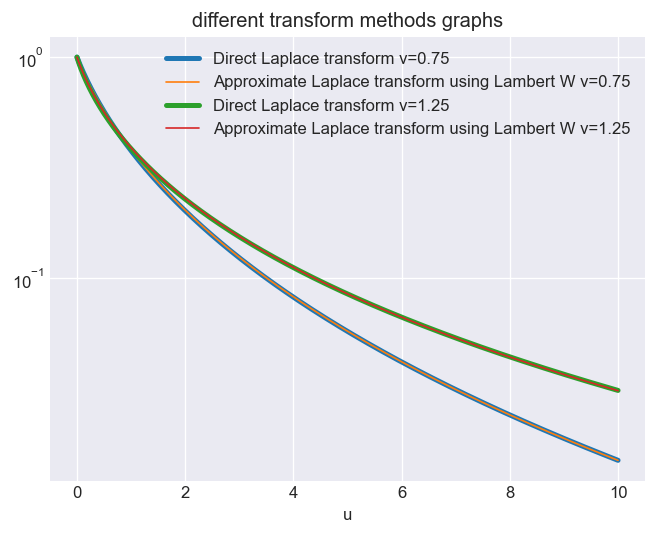

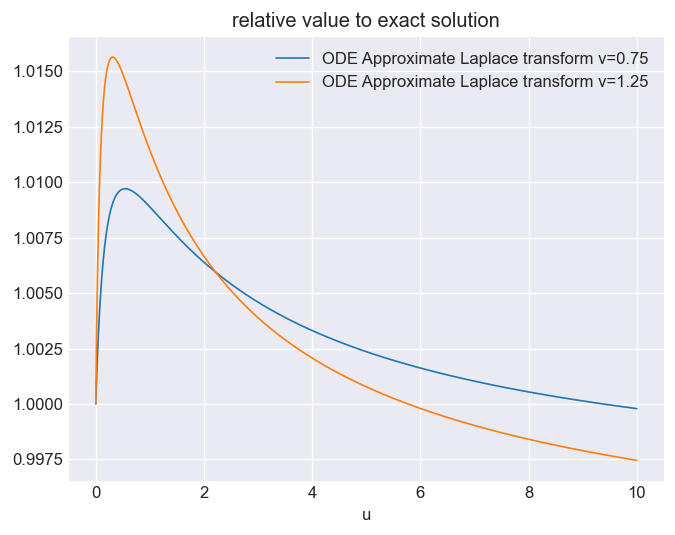

In [8]:
fig, ax = plt.subplots(dpi=120)
plt.title(f'different transform methods graphs')

for v in v0:
    plt.plot(u_r,LaplTrLNFastD(u_r,0.0,v), linewidth=3, label=f'Direct Laplace transform v={v}')
    plt.plot(u_r,LaplTrLNApprox(u_r,v),linewidth=1, label=f'Approximate Laplace transform using Lambert W v={v}')

plt.xlabel('u')
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

fig, ax = plt.subplots(dpi=120)
plt.title(f'relative value to exact solution')
for v in v0:
    plt.plot(u_r,LaplTrLNApprox(u_r,v)/LaplTrLNFastD(u_r,0.0,v),linewidth=1, label=f'ODE Approximate Laplace transform v={v}')

plt.xlabel('u')
plt.legend(loc='upper right')
plt.show()

Next chapter [2.1.Idea,ODE, first results.ipynb](2.ODE/2.1.Idea%2CODE%2C%20first%20results.ipynb)